In [51]:
# подключение google-диска в google colab
# не нужен при запуске на компьютере

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [52]:
import itertools
import pandas as pd
from scipy import stats
import statsmodels.api as sm
%pylab inline

file_path = "/content/gdrive/My Drive/portflio/ml-yandex-course/timeseries/WAG_C_M.csv"

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


In [0]:
df = pd.read_csv(
    file_path,
    sep=';', 
    index_col=['month'], 
    parse_dates=['month'], 
    dayfirst=True
)

# 1. Визуальный анализ ряда

Для начала посмотрим на датасет:

In [54]:
df.head(6)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5
1993-06-01,47.4


Рассмотрим график

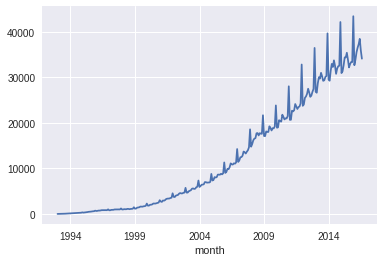

In [55]:
df.WAG_C_M.plot()

Согласно графику, ряд имеет сильную трендовую составляющую, и имеется сезонная составляющая.   
Также видно что имеется растущий размах колебаний, который можно трактовать как проявление гетерокседаксичности. 

Согласно расссмотренным особенностям графика, ряд является нестационарным.

<Figure size 1080x720 with 0 Axes>

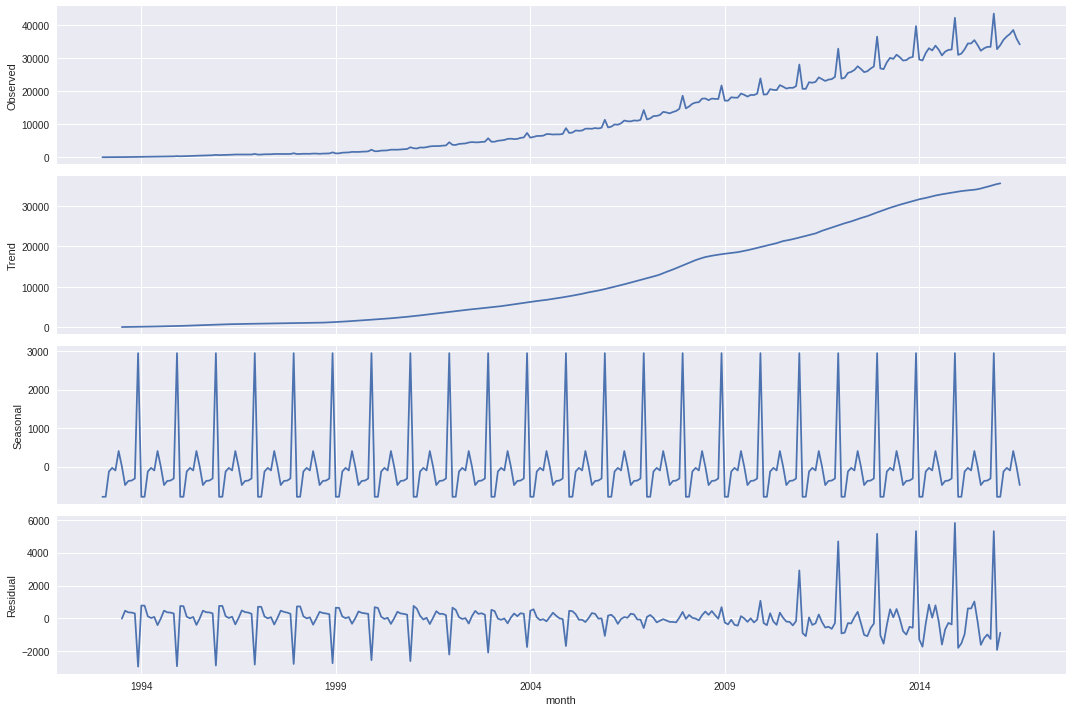

In [56]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(df.WAG_C_M).plot()

# 2. Стабилизация дисперсии (при необходимости)

Проверим необходимость стабилизации дисперсии и выберем оптимальное (приблизительно) значение ляимбда.

In [57]:
min_pvalue = 1.
min_lmd = None

def criteria(lmd):
    return sm.tsa.adfuller(stats.boxcox(df.WAG_C_M, lmbda=lmd))[1]

for lmd in pd.np.arange(0., 3., 0.01):
    if min_lmd is None:
        min_lmd = lmd
        min_pvalue = criteria(lmd)
    else:
        pvalue = criteria(lmd)
        if pvalue < min_pvalue:
            min_lmd = lmd
            min_pvalue = pvalue

print "min lambda: ", min_lmd
print "min p-value", min_pvalue

min lambda:  0.0
min p-value 0.03401037411699027


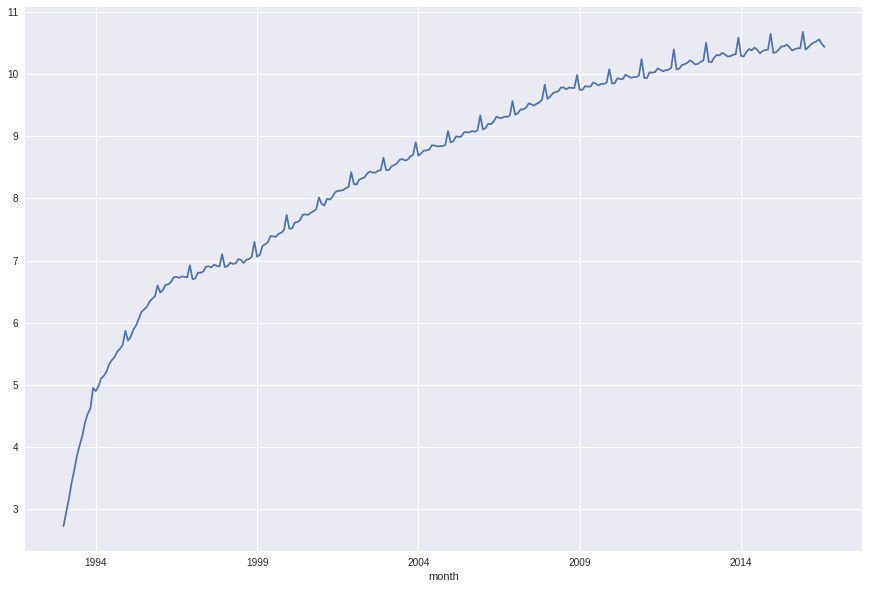

In [58]:
df["boxcox"] = stats.boxcox(df.WAG_C_M, lmbda=0.)
df["boxcox"].plot()

Подобранное значение лябда не равно 1, что говорит о необходимости преобразования. 

# 3. Выбор порядка дифференцирования

Проверим ряд на стационарность с помощью критерия Дики-Фуллера

In [59]:
sm.tsa.adfuller(df.boxcox)

(-3.009569150704227,
 0.03401037411699027,
 14,
 269,
 {'1%': -3.4548957220044336,
  '10%': -2.572527778361272,
  '5%': -2.8723451788613157},
 -1217.2355475245004)

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. 

Однако, при простмотре графиков STL заметно наличие трендовой и сезонной компоненты. Поэтому проведем сезонное, а затем линейное дифференцирование.

## 3.1 Проверка продиффернцированного ряда с d=1 и D=1

Проведем циклическое диффернцирование с периодом 12 и обычное диференцирование.

In [0]:
box_T12D1d0 = df.boxcox - df.boxcox.shift(12)
box_T12D1d1 = (box_T12D1d0 - box_T12D1d0.shift(1))[13:]

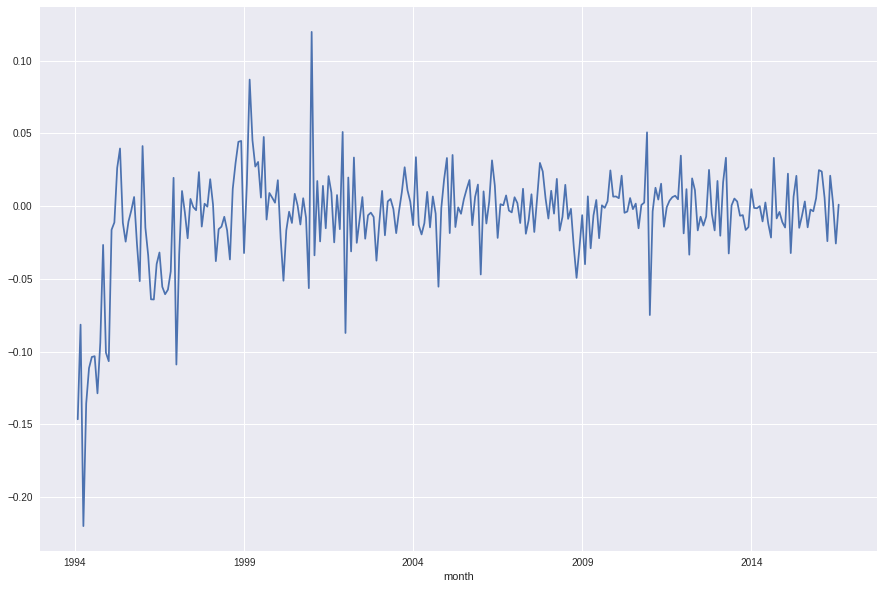

In [61]:
box_T12D1d1.plot()

Проведем аугментированный DF-тест

In [62]:
sm.tsa.adfuller(box_T12D1d1)

(-3.407349893525075,
 0.010710851546579617,
 16,
 254,
 {'1%': -3.456360306409983,
  '10%': -2.572870232500465,
  '5%': -2.8729872043802356},
 -1200.951735659067)

<Figure size 1080x720 with 0 Axes>

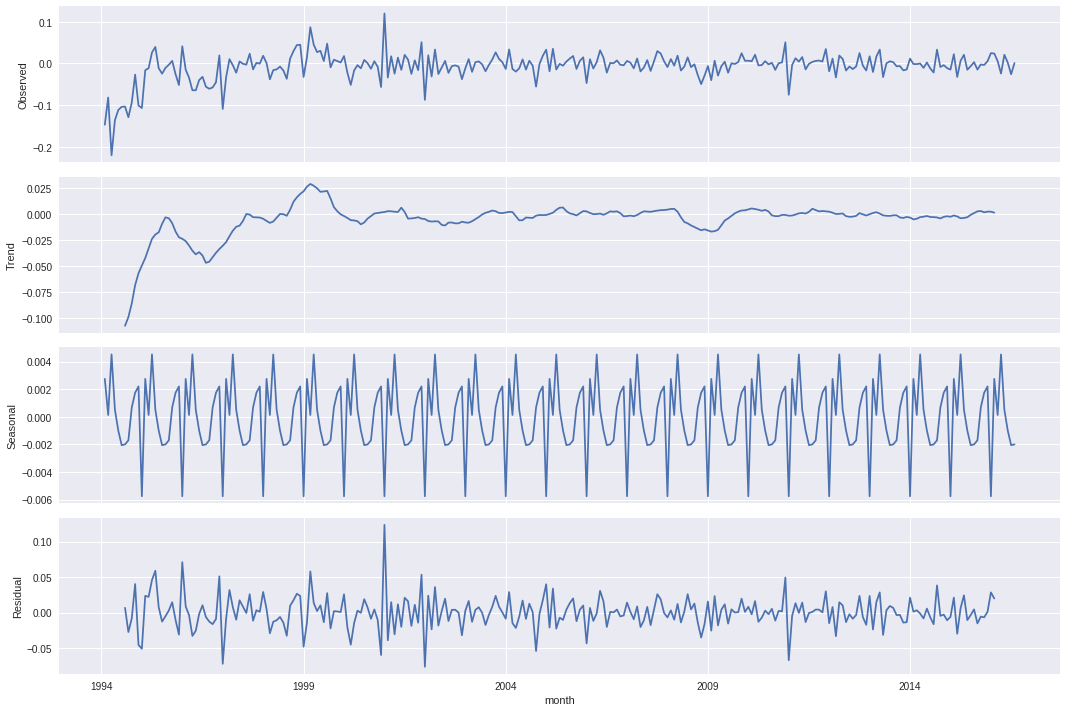

In [63]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(box_T12D1d1).plot()

После подбора параметров дифференцирования на графике исчезла сезонность и почти исчез тренд. Ряд визуально выглядик достаточно стационарным.

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. 

## 3.2 Проверка продиффернцированного ряда с d=1 и D=2

In [0]:
box_T12D2d1 = (box_T12D1d1 - box_T12D1d1.shift(12))[12:]

Проведем DF-тест:

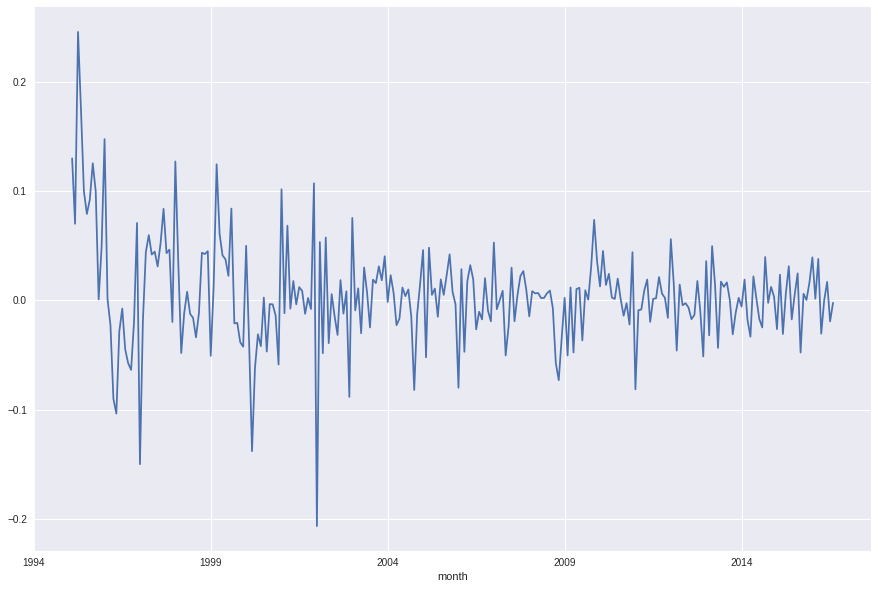

In [65]:
box_T12D2d1.plot()

In [66]:
sm.tsa.adfuller(box_T12D2d1)

(-4.282159913852122,
 0.0004768949598930776,
 16,
 242,
 {'1%': -3.457664132155201,
  '10%': -2.5731749894132916,
  '5%': -2.8735585105960224},
 -1002.6713389294669)

<Figure size 1080x720 with 0 Axes>

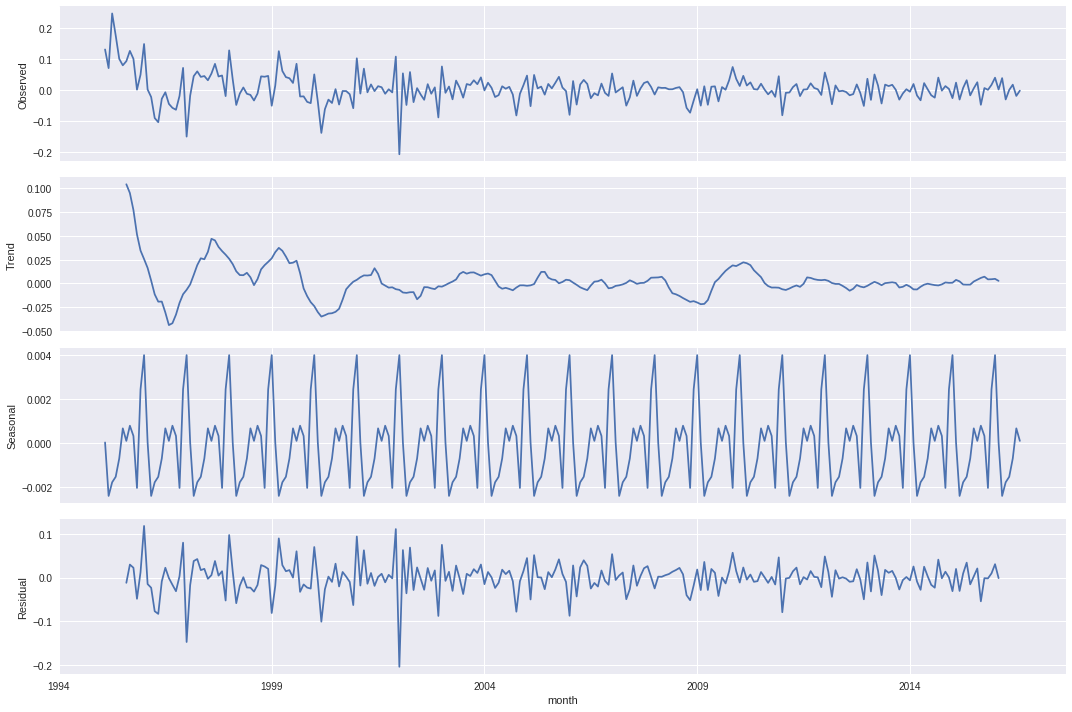

In [67]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(box_T12D2d1).plot()

Визуально виден тренд на STL-декомпозиуии, сезонная составляющая на графике остатков кажется менее значимой по сравнени с предыдущими примерами.

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. Также достигаемый уровень значимости заметно уменьшился.

## 3.3 Проверка продиффернцированного ряда с d=2 и D=1

In [0]:
box_T12D1d2 = (box_T12D1d1 - box_T12D1d1.shift(1))[1:]

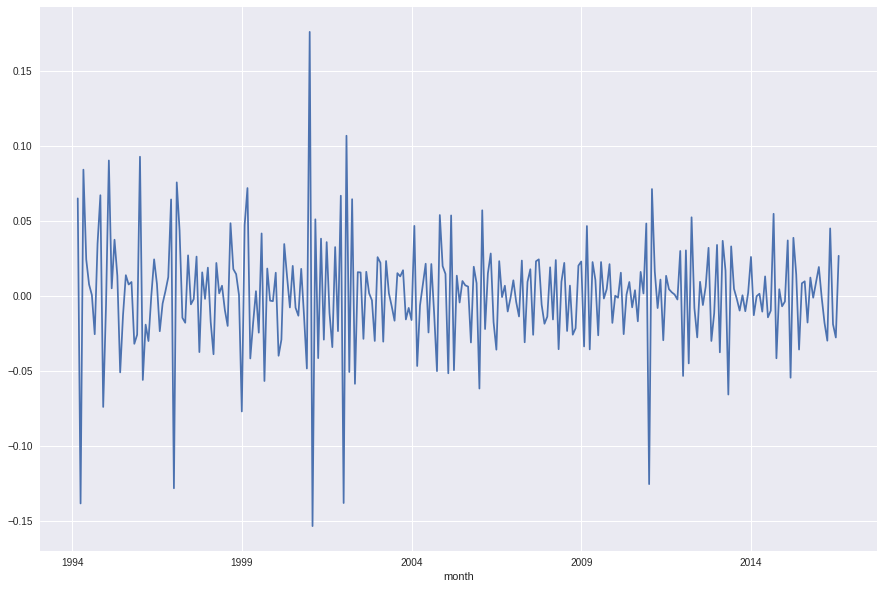

In [69]:
box_T12D1d2.plot()

In [70]:
sm.tsa.adfuller(box_T12D1d2)

(-8.988698961989275,
 6.986521150247654e-15,
 16,
 253,
 {'1%': -3.4564641849494113,
  '10%': -2.572894516864816,
  '5%': -2.873032730098417},
 -1188.3554117067813)

<Figure size 1080x720 with 0 Axes>

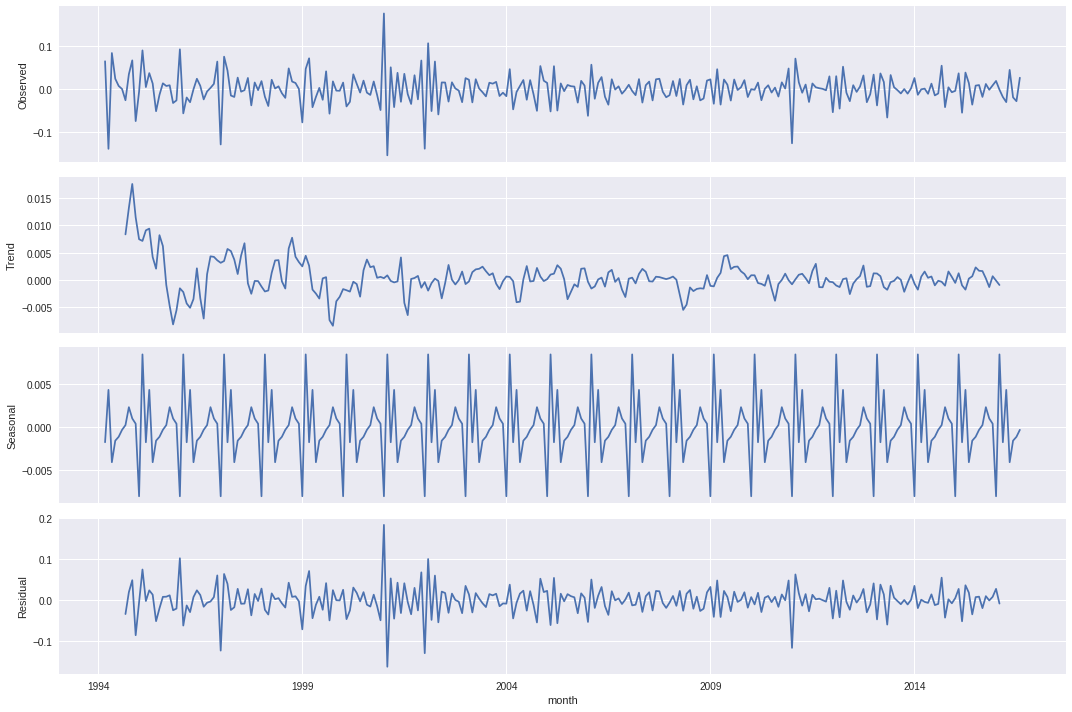

In [71]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(box_T12D1d2).plot()

Визуально видны тренд и подозрение на сезонный тренд на STL-декомпозиции, но в этот раз он меньше.

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. 

## 3.4 Проверка продиффернцированного ряда с d=2 и D=2

In [0]:
box_T12D2d2 = (box_T12D2d1 - box_T12D2d1.shift(1))[1:]

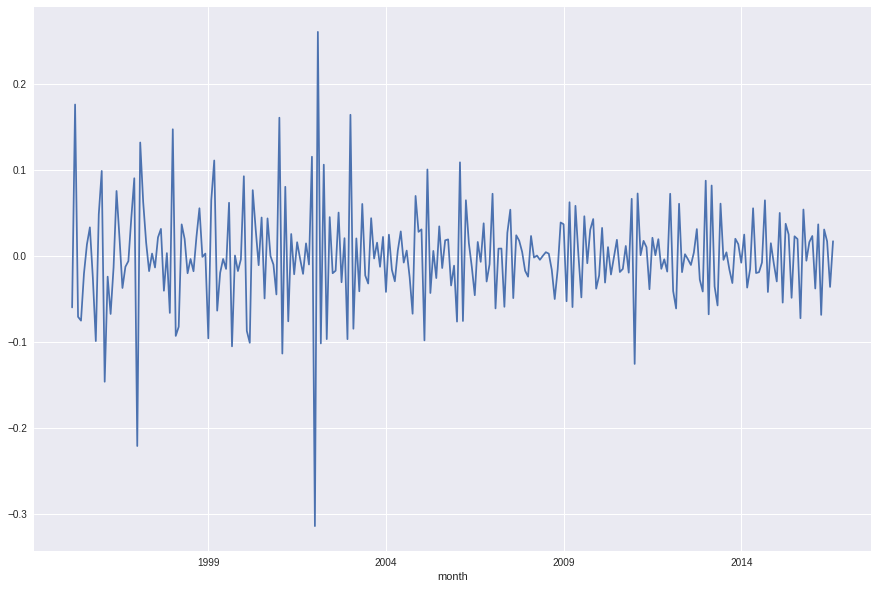

In [73]:
box_T12D2d2.plot()

In [74]:
sm.tsa.adfuller(box_T12D2d2)

(-9.986893172691916,
 2.044196702617491e-17,
 16,
 241,
 {'1%': -3.4577787098622674,
  '10%': -2.573201765981991,
  '5%': -2.873608704758507},
 -987.0589543764422)

<Figure size 1080x720 with 0 Axes>

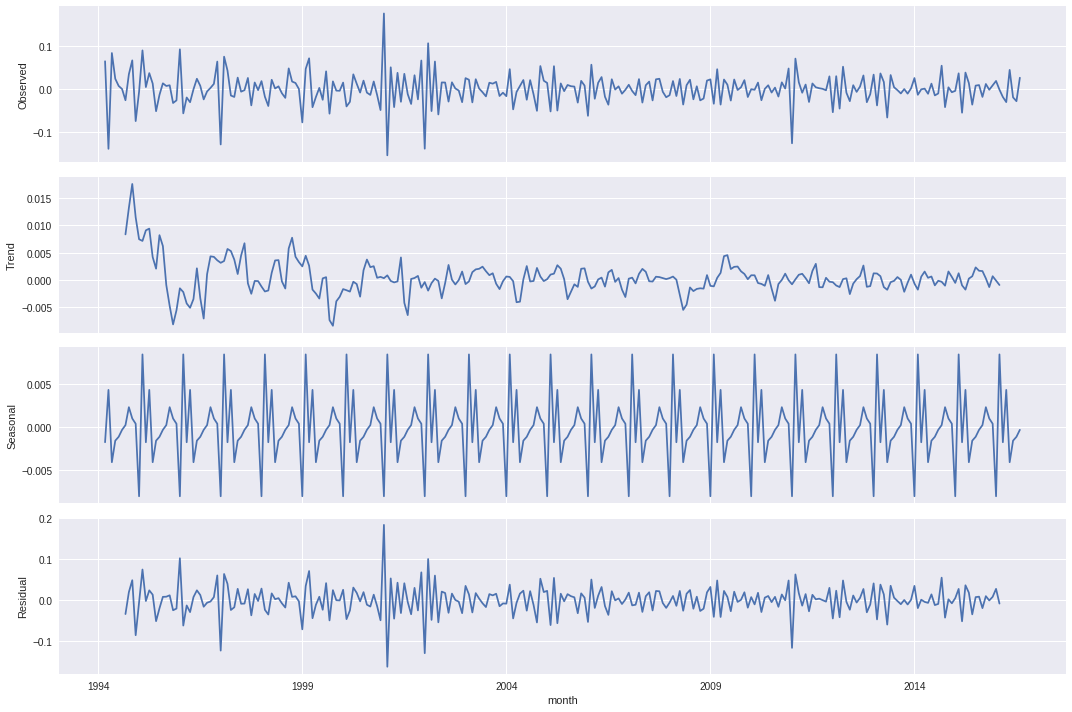

In [75]:
plt.figure(figsize(15,10))
_ = sm.tsa.seasonal_decompose(box_T12D1d2).plot()

Визуально тренд еще остается и все еще видны признаки сезонности.

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. Но достигаемый уровень значимости уменьшился на 2 порядка.

На самом деле я пробовал эти варианты на всем пайплайне ноутбука и этот вариант показал себя лучше всех. Это основная причина почему выбран этот вариант, так как значимых визуальных изменений нету даже при пристальном сравнениии графиков.

## 3.3 Проверка продиффернцированного ряда с d=3 и D=2

In [0]:
box_T12D2d3 = (box_T12D2d2 - box_T12D2d2.shift(1))[1:]

In [77]:
sm.tsa.adfuller(box_T12D2d3)

(-7.092997751678332,
 4.3611708755765794e-10,
 16,
 240,
 {'1%': -3.4578942529658563,
  '10%': -2.573228767361111,
  '5%': -2.8736593200231484},
 -911.9497054411797)

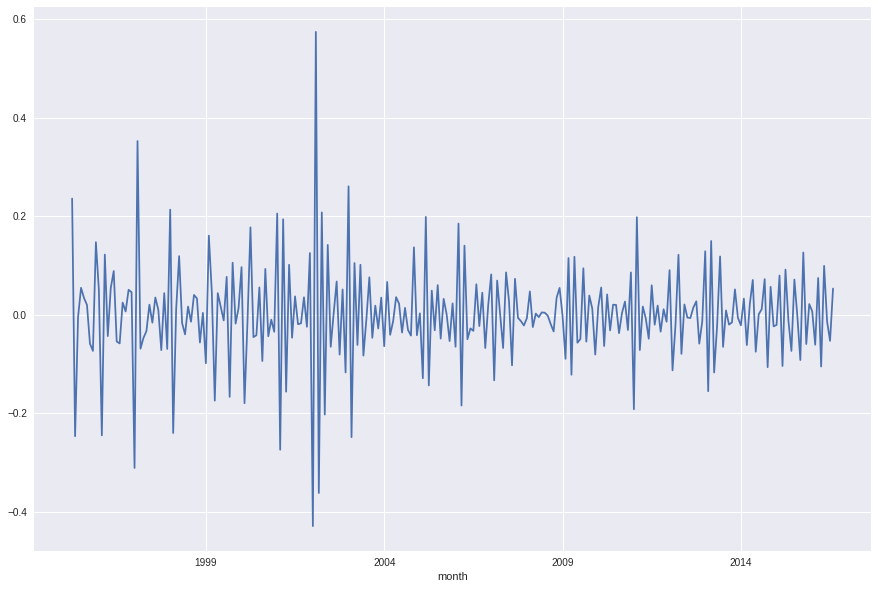

In [78]:
box_T12D2d3.plot()

<Figure size 1080x720 with 0 Axes>

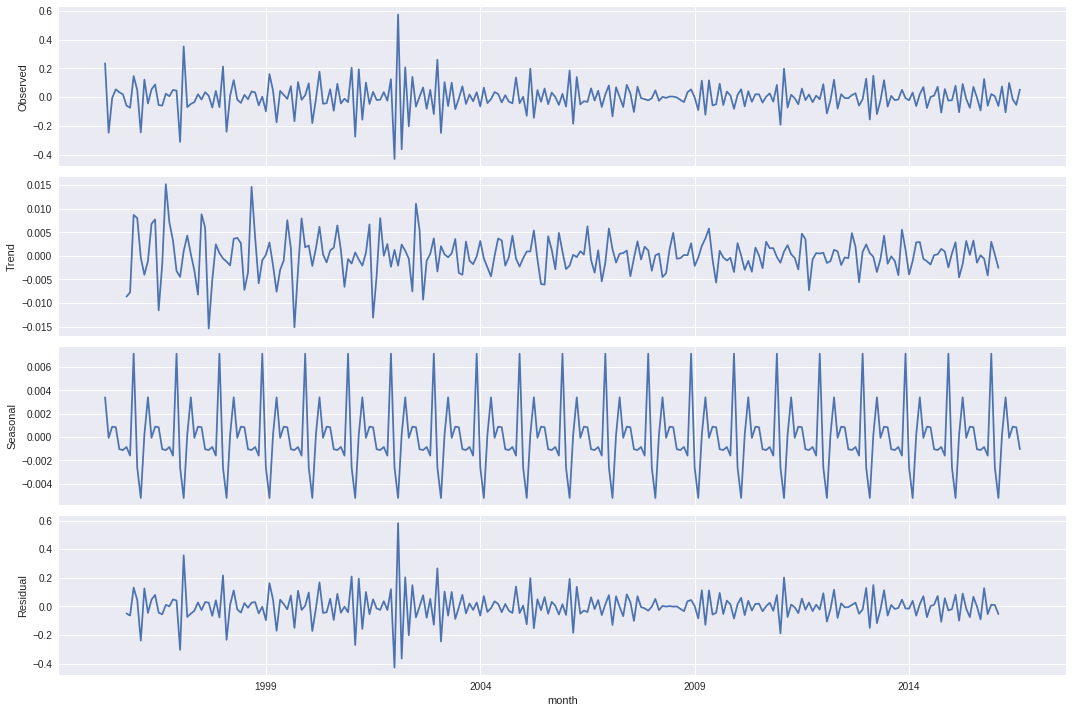

In [79]:
plt.figure(figsize(15, 10))
_ = sm.tsa.seasonal_decompose(box_T12D2d3).plot()

Третее дифференцирование помогло избавиться от тренда.

Значение p-value теста Дики-Фуллера меньше 5% уровня значимости: нулевая гипотеза о стационарности не может быть отвергнута. Но достигаемый уровень значимости увеличелся в несколько раз.

Также при дальнейшей работе с этим вариантом тест Ljung-Box  стал идентифицировать наличие автокоррелированности остатков. А также был сильный разброс при низком смещении, что является признаком переобученности

Поэтому останвимся на параметрах D=2 и d=2.

# 4. Выбор начальных приближений для p, q, P, Q

Построим автокорреляционную функцию

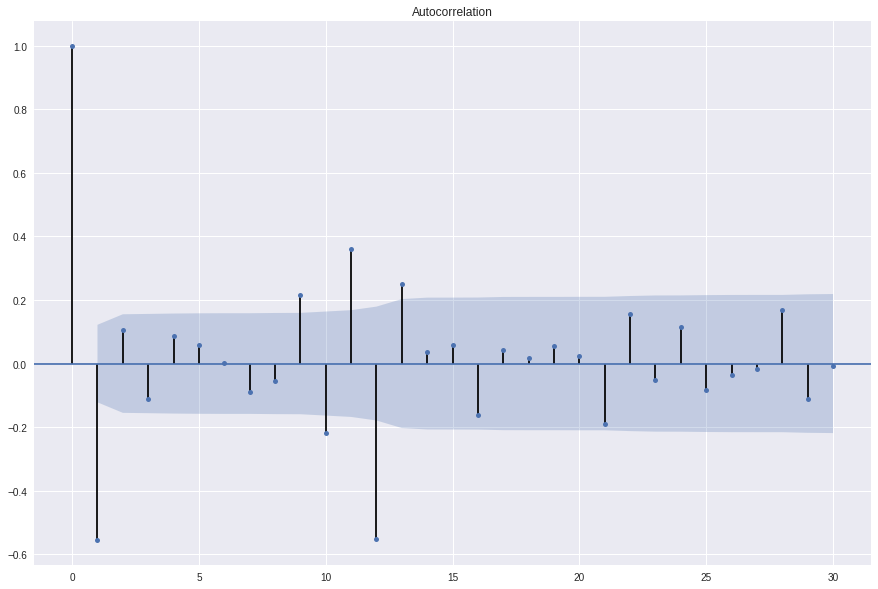

In [80]:
_ = sm.graphics.tsa.plot_acf(box_T12D2d2.values.squeeze(), lags=30)

Согласно автокорреляционной функции у ряда имеется сезонность, которая остается значимой на первом лаге, поэтому Q будет равна 1.
В качестве q выберем лаг 13, так как аналогичная точка предыдущего периода не значима.

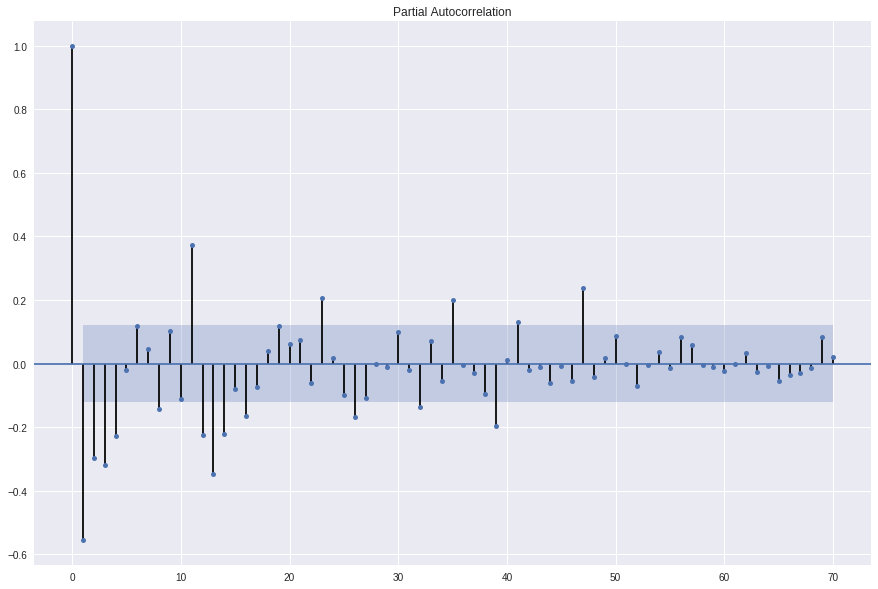

In [81]:
_ = sm.graphics.tsa.plot_pacf(box_T12D2d2.values.squeeze(), lags=70)

На графике видно, что начиная с 4-го сезонного лага нарушается цикличность (период стал меньше), поэтому P возьмем равным 4. (на локальном компьютере возникал сильный разброс из-за вычислительных погрешностей начиная с 4-го лага).
В качестве начального значения p возьмем 8. Дальнейшие значимые точки по моему мнению относятся либо к сезонности, либо к переобучению.

# 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [0]:
ps = range(0, 8)
d = 2
qs = range(0, 6)
Ps = range(0, 3)
D = 2
Qs = range(0, 3)

init_p = 8
init_q = 13
init_P = 3
init_Q = 1

In [97]:
parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

432

In [0]:
def init_pPqQ(p,q,P,Q, d, D):
    param = (p, q, P, Q)
    aic = None
    try:
        model = sm.tsa.statespace.SARIMAX(
            df.boxcox, 
            order=(
                param[0], 
                d, 
                param[1]
            ), 
            seasonal_order=(
                param[2], 
                D, 
                param[3], 
                12
            )
        ).fit(disp=-1)
        aic = model.aic
        return aic
    except ValueError:
        print('wrong parameters:', param)
        return None

In [99]:
%%time
results = []
best_aic = float("inf")
best_param = None
warnings.filterwarnings('ignore')


init_aic = init_pPqQ(init_p, init_q, init_P, init_Q, 3, 1)

if init_aic is not None:
    best_aic = init_aic
    best_param = (init_p, init_q, init_P, init_Q)

for idx, param in enumerate(parameters_list):
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(
            df.boxcox, 
            order=(
                param[0], 
                d, 
                param[1]
            ), 
            seasonal_order=(
                param[2], 
                D, 
                param[3], 
                12
            )
        ).fit(disp=-1)
        print(idx, 'correct parameters:', param)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (8, 13, 3, 1))
('wrong parameters:', (0, 0, 0, 0))
(1, 'correct parameters:', (0, 0, 0, 1))
('wrong parameters:', (0, 0, 0, 2))
(3, 'correct parameters:', (0, 0, 1, 0))
(4, 'correct parameters:', (0, 0, 1, 1))
('wrong parameters:', (0, 0, 1, 2))
(6, 'correct parameters:', (0, 0, 2, 0))
(7, 'correct parameters:', (0, 0, 2, 1))
('wrong parameters:', (0, 0, 2, 2))
(9, 'correct parameters:', (0, 1, 0, 0))
(10, 'correct parameters:', (0, 1, 0, 1))
('wrong parameters:', (0, 1, 0, 2))
(12, 'correct parameters:', (0, 1, 1, 0))
(13, 'correct parameters:', (0, 1, 1, 1))
('wrong parameters:', (0, 1, 1, 2))
(15, 'correct parameters:', (0, 1, 2, 0))
(16, 'correct parameters:', (0, 1, 2, 1))
('wrong parameters:', (0, 1, 2, 2))
(18, 'correct parameters:', (0, 2, 0, 0))
(19, 'correct parameters:', (0, 2, 0, 1))
('wrong parameters:', (0, 2, 0, 2))
(21, 'correct parameters:', (0, 2, 1, 0))
(22, 'correct parameters:', (0, 2, 1, 1))
('wrong parameters:', (0, 2, 1, 2))
(24, 'correct p

Рассмотрим кандидатов:

In [100]:
print(results)

[[(0, 0, 0, 1), -913.3410352623096], [(0, 0, 1, 0), -829.6643336567869], [(0, 0, 1, 1), -927.3506451254448], [(0, 0, 2, 0), -851.9408978353274], [(0, 0, 2, 1), -930.9610347872645], [(0, 1, 0, 0), -866.7023523420692], [(0, 1, 0, 1), -1055.370144307906], [(0, 1, 1, 0), -991.2691723437042], [(0, 1, 1, 1), -1084.0291217994352], [(0, 1, 2, 0), -1014.3746412910913], [(0, 1, 2, 1), -1082.7409456827372], [(0, 2, 0, 0), nan], [(0, 2, 0, 1), nan], [(0, 2, 1, 0), nan], [(0, 2, 1, 1), nan], [(0, 2, 2, 0), nan], [(0, 2, 2, 1), nan], [(0, 3, 0, 0), nan], [(0, 3, 0, 1), nan], [(0, 3, 1, 0), nan], [(0, 3, 1, 1), nan], [(0, 3, 2, 0), nan], [(0, 3, 2, 1), nan], [(0, 4, 0, 0), nan], [(0, 4, 0, 1), nan], [(0, 4, 1, 0), nan], [(0, 4, 1, 1), nan], [(0, 4, 2, 0), nan], [(0, 4, 2, 1), nan], [(0, 5, 0, 0), nan], [(0, 5, 0, 1), nan], [(0, 5, 1, 0), nan], [(0, 5, 1, 1), nan], [(0, 5, 2, 0), nan], [(0, 5, 2, 1), nan], [(1, 0, 0, 0), -820.6258563879403], [(1, 0, 0, 1), -1008.5778579469113], [(1, 0, 1, 0), -934.868

In [101]:
print("В качестве победителя выберем модель с параметрами p=%s, q=%s, P=%s, Q=%s."%best_param)

В качестве победителя выберем модель с параметрами p=5, q=0, P=1, Q=1.


# 6. Анализ остатков построенной модели

Рассмотим лучшую модель

In [102]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                             boxcox   No. Observations:                  284
Model:             SARIMAX(5, 2, 0)x(1, 2, 1, 12)   Log Likelihood                 557.479
Date:                            Sun, 10 Feb 2019   AIC                          -1098.959
Time:                                    16:59:08   BIC                          -1069.767
Sample:                                01-01-1993   HQIC                         -1087.255
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0023      0.049    -20.648      0.000      -1.097      -0.907
ar.L2         -0.8014      0.072    -11.115      0.000      -0.943      -0.660
ar.L3         -0.5406      0.082     -6.589      0.000      -0.701      -0.380
ar.L4         -0.3498      0.080     -4.370      0.000      -0.507      -0.193
ar.L5         -0.1471      0.074     -1.988      0.047      -0.292      -0.002
ar.S.L12      -0.4326      0.052     -8.246      0.000      -0.535      -0.330
ma.S.L12      -0.9578      0.150     -6.395      0.000      -1.251      -0.664
sigma2         0.0007    9.7e-05      6.880      0.000       0.000       0.001
===================================================================================
Ljung-Box (Q):                       63.36   Jarque-Bera (JB):                85.08
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.34   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Критерий Льюнга-Бокса вывел достигаемый уровень значимоси меньше 5%, значит гипотезу об автокоррелированности остатков можно отвергнуть.

Критерий Стьюдента: p=0.763723
Критерий Дики-Фуллера: p=0.000764


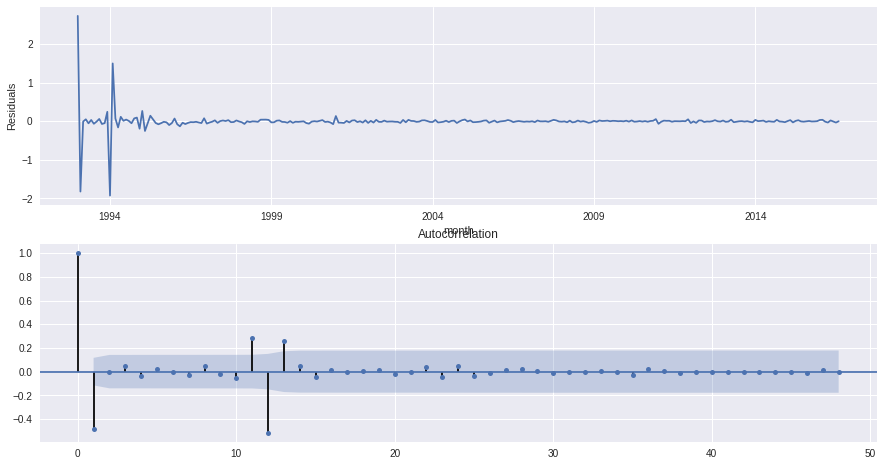

In [110]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid, 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Выбрав уровень значимости 0.05, можно утверждать следующее:
Остатки стационарны согласно критерию Дикки-Фуллера, достигаемый уровень значемости меньше 5%.

Остатки несмещены согласно критерию Стьюдента, так как достигаемый уровень значимости велик. 

Также можно заключить, что данные неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Посмотрим, насколько хорошо модель описывает данные:

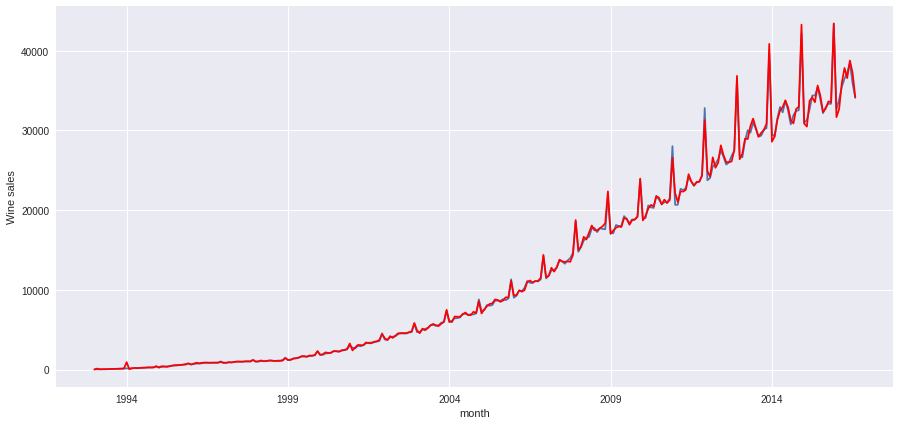

In [111]:
df['model'] = invboxcox(best_model.fittedvalues, 0)
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

Согласно графику, модель хорошо описывает данные.

# 7. Прогнозирование с помощью финальной модели.

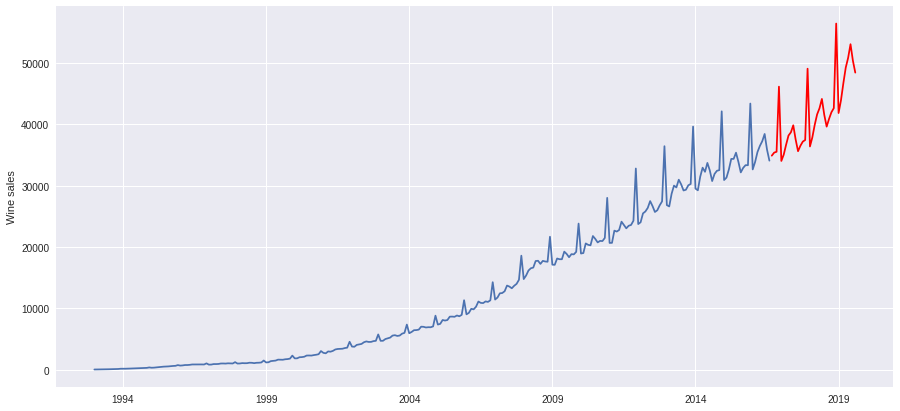

In [112]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df, future])
df2['forecast'] = invboxcox(best_model.predict(start=284, end=284+35), 0)

plt.figure(figsize(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

Прогноз выглядит достаточно адекватным:
 - прогноз воспроизел сезонность ряда
 - Прогноз не выглядит смещенным относительно ряда.
 - Прогноз уловил восходящий тренд
